In [22]:
import sys
!{sys.executable} -m pip install pickle5 pandas nltk tqdm regex spacy seaborn sklearn
!{sys.executable} -m spacy download en_core_web_sm

import pickle5 as pickle
import pandas as pd
import nltk
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer 
from nltk.tokenize import word_tokenize
from nltk import pos_tag

import regex as re

import spacy 

from matplotlib import *
from matplotlib import pyplot as plt
import seaborn as sns

from tqdm.autonotebook import tqdm
tqdm.pandas()

  Using cached sklearn-0.0.tar.gz (1.1 kB)
     |████████████████████████████████| 7.3 MB 2.7 MB/s eta 0:00:01
  Created wheel for sklearn: filename=sklearn-0.0-py2.py3-none-any.whl size=1316 sha256=ef4c550a48b36c867000de223e0720278896fbe17bec94877faf9eb9125da87e
  Stored in directory: /Users/s.konkiel/Library/Caches/pip/wheels/e4/7b/98/b6466d71b8d738a0c547008b9eb39bf8676d1ff6ca4b22af1c
Successfully built sklearn
     |████████████████████████████████| 13.7 MB 10.8 MB/s eta 0:00:01


✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/s.konkiel/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [12]:
# Load saved data
with open("../getting_started/articles_df.pkl", "rb") as fh:
    articles = pickle.load(fh)
    
articles.head()

,section_title,text,article_id
0,,"On 26 January 2010, at an ordinary airport hot...",0213936a-340f-47cf-a5e6-2ca353343a77
1,PART 2: CAN ALZHEIMER'S PREVENTION INITIATIVE ...,Reiman was not alone in thinking about such tr...,0213936a-340f-47cf-a5e6-2ca353343a77
2,PART 3: TRIALS IN COLOMBIA AND THE U.S. FOR TH...,During two recent all-day discussions with aca...,0213936a-340f-47cf-a5e6-2ca353343a77
3,"PART 4: FOR SHARED PREVENTION TRIALS, DEVIL IS...","In Phoenix, a roomful of senior industry and a...",0213936a-340f-47cf-a5e6-2ca353343a77
4,"Drug Selection: Can We Have Privacy, Please!",If anyone was hoping that representatives from...,0213936a-340f-47cf-a5e6-2ca353343a77


## Section names
There may be relationships between data citations and where in a document the citation occurs. Let's do some basic cleanup and EDA on section names, with this in mind.

In [13]:
# How many sections per article?
section_counts = articles.groupby('article_id')['section_title'].count()
section_counts.describe()

count    14316.000000
mean        18.071668
std         23.617739
min          1.000000
25%         10.000000
50%         14.000000
75%         20.000000
max       1120.000000
Name: section_title, dtype: float64

Text(0, 0.5, 'articles')

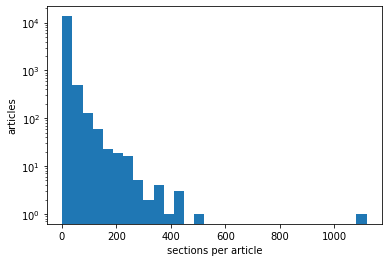

In [14]:
# How many sections per article?
plt = section_counts.plot(kind='hist', bins=30, logy=True)
plt.set_xlabel('sections per article')
plt.set_ylabel('articles')

<AxesSubplot:>

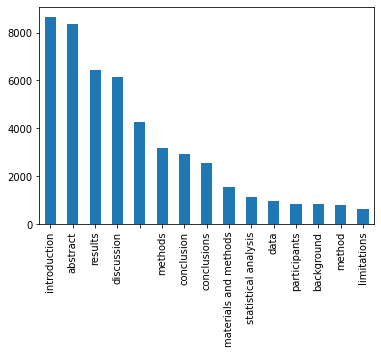

In [15]:
# quick look at top section titles
articles['section_title'].str.lower().value_counts()[:15].plot(kind='bar')

In [16]:
# tokenization
def tokenize(text):
    '''prepare the text for cleaning by tokenizing strings into words'''
    try:
        sentence_list = nltk.sent_tokenize(text)
        tokenizer = nltk.RegexpTokenizer(r"\w+")
        word_list = [tokenizer.tokenize(s) for s in sentence_list]
    except:
        word_list = text
    
    return word_list

In [17]:
articles['section_title_cleaned'] = articles['section_title'].apply(lambda x: str(x)) # make sure nulls are treated as str
articles['section_title_lower'] = articles['section_title_cleaned'].str.lower() # lowercase standardization
articles['section_title_cleaned'] = articles['section_title_lower'].apply(lambda x: re.sub(r'[^\w\d\s\']+', '', x)) # remove all non-word characters
articles['section_title_tokenized'] = articles['section_title_cleaned'].progress_apply(word_tokenize) # tokenize

articles.loc[2,'section_title_tokenized'] # check output

  0%|          | 0/258714 [00:00<?, ?it/s]

['part',
 '3',
 'trials',
 'in',
 'colombia',
 'and',
 'the',
 'us',
 'for',
 'those',
 'at',
 'highest',
 'risk']

In [18]:
# remove stopwords
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

articles['section_title_tokenized_stop_rem'] = articles['section_title_tokenized'].progress_apply(lambda x: [word for word in x if word not in stop_words])

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/s.konkiel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


  0%|          | 0/258714 [00:00<?, ?it/s]

In [48]:
# lemmatize with POS tags applied
# use spaCy to do this in a more streamlined fashion than NLTK # https://www.machinelearningplus.com/nlp/lemmatization-examples-python/#wordnetlemmatizerwithappropriatepostag

nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])

### If fresh data lemmatization needed - takes ~7m
# def lemmatize(l):
#     '''use context-aware lemmatization from spacy on cleaned and stopword-removed tokens'''
#     string = ' '.join(l) 
#     doc = nlp(string)
#     tokens = [token.lemma_ for token in doc]
#     string = ' '.join(tokens)
#     return string

# articles['spacy'] = articles['section_title_tokenized_stop_rem'].progress_apply(lemmatize)

# articles.to_pickle('./interim/articles_lemmatized.pkl')

### If fresh data data not needed (loads faster)
f = open('./interim/articles_lemmatized.pkl', 'rb')
articles = pickle.load(f)

articles.head()

,section_title,text,article_id,section_title_cleaned,section_title_lower,section_title_tokenized,section_title_tokenized_stop_rem,spacy
0,,"On 26 January 2010, at an ordinary airport hot...",0213936a-340f-47cf-a5e6-2ca353343a77,,,[],[],
1,PART 2: CAN ALZHEIMER'S PREVENTION INITIATIVE ...,Reiman was not alone in thinking about such tr...,0213936a-340f-47cf-a5e6-2ca353343a77,part 2 can alzheimer's prevention initiative b...,part 2: can alzheimer's prevention initiative ...,"[part, 2, can, alzheimer, 's, prevention, init...","[part, 2, alzheimer, 's, prevention, initiativ...",part 2 alzheimer 's prevention initiative brea...
2,PART 3: TRIALS IN COLOMBIA AND THE U.S. FOR TH...,During two recent all-day discussions with aca...,0213936a-340f-47cf-a5e6-2ca353343a77,part 3 trials in colombia and the us for those...,part 3: trials in colombia and the u.s. for th...,"[part, 3, trials, in, colombia, and, the, us, ...","[part, 3, trials, colombia, us, highest, risk]",part 3 trial colombia we high risk
3,"PART 4: FOR SHARED PREVENTION TRIALS, DEVIL IS...","In Phoenix, a roomful of senior industry and a...",0213936a-340f-47cf-a5e6-2ca353343a77,part 4 for shared prevention trials devil is i...,"part 4: for shared prevention trials, devil is...","[part, 4, for, shared, prevention, trials, dev...","[part, 4, shared, prevention, trials, devil, d...",part 4 share prevention trial devil detail
4,"Drug Selection: Can We Have Privacy, Please!",If anyone was hoping that representatives from...,0213936a-340f-47cf-a5e6-2ca353343a77,drug selection can we have privacy please,"drug selection: can we have privacy, please!","[drug, selection, can, we, have, privacy, please]","[drug, selection, privacy, please]",drug selection privacy please


In [49]:
# Drop section titles that have state abbreviations from tables
# TODO: How did other teams handle this aspect of dataset cleaning?

articles.drop(index=[219679, 219682, 219680, 219683, 219681], inplace=True)

In [50]:
# Find and visualize n-grams for common terms in section titles
from nltk.util import ngrams
from sklearn.feature_extraction.text import CountVectorizer

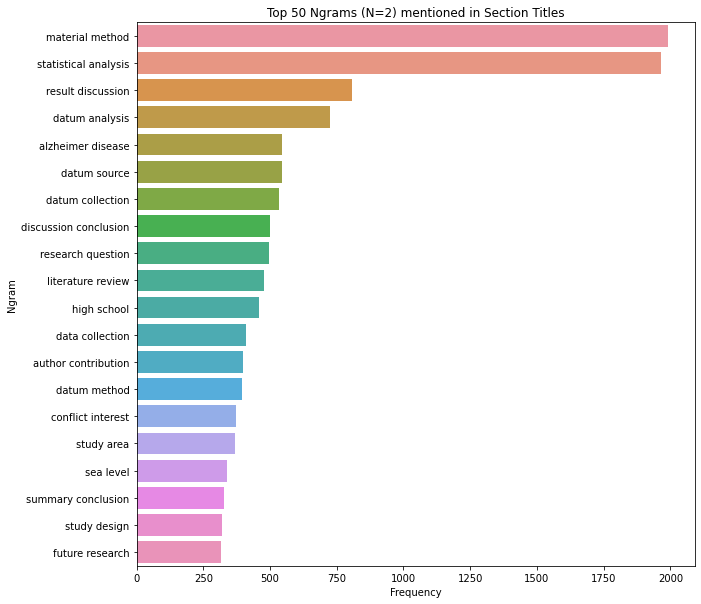

In [51]:
# From data_cleanup notebook, updated to accomodate both bigrams and trigrams
def plot_top_ngrams_barchart(text, n=2):
    stop=set(stopwords.words('english'))

    new=text.str.split()
    new=new.values.tolist()
    corpus=[word for i in new for word in i]

    def _get_top_ngram(corpus, n=None):
        vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
        bag_of_words = vec.transform(corpus)
        sum_words = bag_of_words.sum(axis=0) 
        words_freq = [(word, sum_words[0, idx]) 
                      for word, idx in vec.vocabulary_.items()]
        words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
        return words_freq[:20]

    top_n_bigrams=_get_top_ngram(text,n)[:50]
    x,y=map(list,zip(*top_n_bigrams))
    plt.figure(figsize=(10,10))
    plt.xlabel(f"Frequency")
    plt.ylabel(f"Ngram")
    plt.title(f"Top 50 Ngrams (N={n}) mentioned in Section Titles")
    sns.barplot(x=y,y=x)

plot_top_ngrams_barchart(articles['spacy'],2)

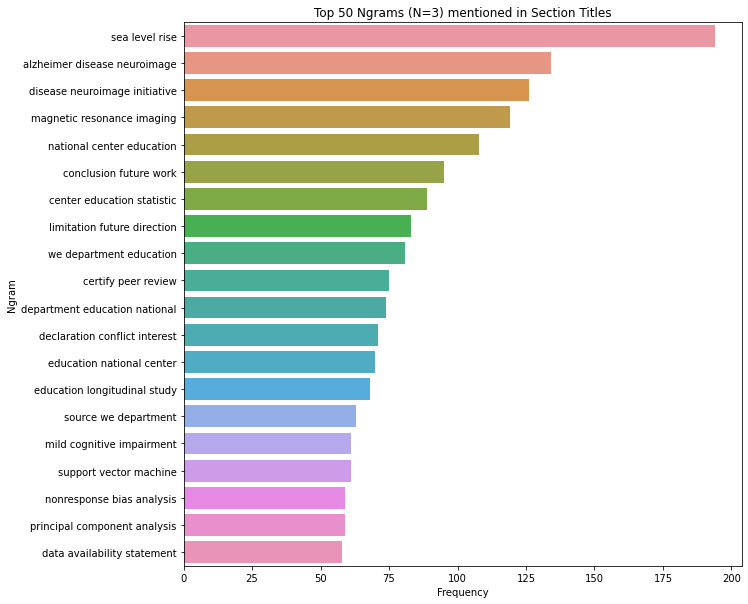

In [52]:
# Plot trigrams
plot_top_ngrams_barchart(articles['spacy'],3)

In [57]:
# Implement POS tags for section titles
# https://spacy.io/usage/linguistic-features#pos-tagging

def pos(text):
    doc = nlp(text)
    tags = [(token.lemma_, token.pos_) for token in doc]
    return tags    

# articles['spacy_pos'] = articles['section_title_cleaned'].progress_apply(nlp)
articles['spacy_pos'] = articles['section_title_cleaned'].progress_apply(pos)
articles.head(20)

  0%|          | 0/258709 [00:00<?, ?it/s]

,section_title,text,article_id,section_title_cleaned,section_title_lower,section_title_tokenized,section_title_tokenized_stop_rem,spacy,spacy_pos
0,,"On 26 January 2010, at an ordinary airport hot...",0213936a-340f-47cf-a5e6-2ca353343a77,,,[],[],,[]
1,PART 2: CAN ALZHEIMER'S PREVENTION INITIATIVE ...,Reiman was not alone in thinking about such tr...,0213936a-340f-47cf-a5e6-2ca353343a77,part 2 can alzheimer's prevention initiative b...,part 2: can alzheimer's prevention initiative ...,"[part, 2, can, alzheimer, 's, prevention, init...","[part, 2, alzheimer, 's, prevention, initiativ...",part 2 alzheimer 's prevention initiative brea...,"[(part, NOUN), (2, NUM), (can, AUX), (alzheime..."
2,PART 3: TRIALS IN COLOMBIA AND THE U.S. FOR TH...,During two recent all-day discussions with aca...,0213936a-340f-47cf-a5e6-2ca353343a77,part 3 trials in colombia and the us for those...,part 3: trials in colombia and the u.s. for th...,"[part, 3, trials, in, colombia, and, the, us, ...","[part, 3, trials, colombia, us, highest, risk]",part 3 trial colombia we high risk,"[(part, NOUN), (3, NUM), (trial, NOUN), (in, A..."
3,"PART 4: FOR SHARED PREVENTION TRIALS, DEVIL IS...","In Phoenix, a roomful of senior industry and a...",0213936a-340f-47cf-a5e6-2ca353343a77,part 4 for shared prevention trials devil is i...,"part 4: for shared prevention trials, devil is...","[part, 4, for, shared, prevention, trials, dev...","[part, 4, shared, prevention, trials, devil, d...",part 4 share prevention trial devil detail,"[(part, NOUN), (4, NUM), (for, ADP), (share, V..."
4,"Drug Selection: Can We Have Privacy, Please!",If anyone was hoping that representatives from...,0213936a-340f-47cf-a5e6-2ca353343a77,drug selection can we have privacy please,"drug selection: can we have privacy, please!","[drug, selection, can, we, have, privacy, please]","[drug, selection, privacy, please]",drug selection privacy please,"[(drug, NOUN), (selection, NOUN), (can, AUX), ..."
5,Safety: How Much Is Enough?,The question of how much safety data are suffi...,0213936a-340f-47cf-a5e6-2ca353343a77,safety how much is enough,safety: how much is enough?,"[safety, how, much, is, enough]","[safety, much, enough]",safety much enough,"[(safety, NOUN), (how, ADV), (much, ADJ), (be,..."
6,Efficacy: How Little Is Enough?,Must a drug have shown efficacy in clinical tr...,0213936a-340f-47cf-a5e6-2ca353343a77,efficacy how little is enough,efficacy: how little is enough?,"[efficacy, how, little, is, enough]","[efficacy, little, enough]",efficacy little enough,"[(efficacy, NOUN), (how, ADV), (little, ADJ), ..."
7,Dose: Still a Black Box,Industry scientists suggested that a pre-sympt...,0213936a-340f-47cf-a5e6-2ca353343a77,dose still a black box,dose: still a black box,"[dose, still, a, black, box]","[dose, still, black, box]",dose still black box,"[(dose, VERB), (still, ADV), (a, DET), (black,..."
8,"PART 5: MAKING TRIALS WORK FOR PATIENT, SPONSO...",Exactly how to correctly fashion a pre-symptom...,0213936a-340f-47cf-a5e6-2ca353343a77,part 5 making trials work for patient sponsor ...,"part 5: making trials work for patient, sponso...","[part, 5, making, trials, work, for, patient, ...","[part, 5, making, trials, work, patient, spons...",part 5 make trial work patient sponsor regulator,"[(part, NOUN), (5, NUM), (make, VERB), (trial,..."
9,Abstract,Abstract This study examined disparities in lu...,56951ddb-95e5-4a51-a2e4-f9b2c5ce93b0,abstract,abstract,[abstract],[abstract],abstract,"[(abstract, ADJ)]"


In [58]:
articles.to_pickle('./interim/articles_lemmatized.pkl')

In [59]:
# Find sections where dataset citations are most likely to occur using train dataset
cols = ['section_title', 'text', 'article_id', 'section_title_tokenized_stop_rem', 'spacy_pos']

sections_df = articles[cols]
del articles

sections_df.head()

,section_title,text,article_id,section_title_tokenized_stop_rem,spacy_pos
0,,"On 26 January 2010, at an ordinary airport hot...",0213936a-340f-47cf-a5e6-2ca353343a77,[],[]
1,PART 2: CAN ALZHEIMER'S PREVENTION INITIATIVE ...,Reiman was not alone in thinking about such tr...,0213936a-340f-47cf-a5e6-2ca353343a77,"[part, 2, alzheimer, 's, prevention, initiativ...","[(part, NOUN), (2, NUM), (can, AUX), (alzheime..."
2,PART 3: TRIALS IN COLOMBIA AND THE U.S. FOR TH...,During two recent all-day discussions with aca...,0213936a-340f-47cf-a5e6-2ca353343a77,"[part, 3, trials, colombia, us, highest, risk]","[(part, NOUN), (3, NUM), (trial, NOUN), (in, A..."
3,"PART 4: FOR SHARED PREVENTION TRIALS, DEVIL IS...","In Phoenix, a roomful of senior industry and a...",0213936a-340f-47cf-a5e6-2ca353343a77,"[part, 4, shared, prevention, trials, devil, d...","[(part, NOUN), (4, NUM), (for, ADP), (share, V..."
4,"Drug Selection: Can We Have Privacy, Please!",If anyone was hoping that representatives from...,0213936a-340f-47cf-a5e6-2ca353343a77,"[drug, selection, privacy, please]","[(drug, NOUN), (selection, NOUN), (can, AUX), ..."


In [ ]:
'''
https://jakevdp.github.io/PythonDataScienceHandbook/05.05-naive-bayes.html
https://www.kaggle.com/c/coleridgeinitiative-show-us-the-data/data


next steps
1. load train.csv from data files
2. merge with sections_df (outer)
3. apply flag to each section if overall article_id matches those articles with dataset names attached
4. search the text of each section for matched articles to find if dataset name appears
5. if it appears, flag it
6. run linear regression or naive bayes model (?) to find features of section titles for sections that have data citations

'''